In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("SocialMediaSimilarity").getOrCreate()

In [3]:
data = spark.read.csv('/content/mediadataset.csv', header=True, inferSchema=True)
data.show(5, truncate=False)

+----------------------------------------------------+-----------+--------------+-----------+------------------------------------------+
|Text                                                |Sentiment  |User          |Platform   |Hashtags                                  |
+----------------------------------------------------+-----------+--------------+-----------+------------------------------------------+
| Enjoying a beautiful day at the park!              | Positive  | User123      | Twitter   | #Nature #Park                            |
| Traffic was terrible this morning.                 | Negative  | CommuterX    | Twitter   | #Traffic #Morning                        |
| Just finished an amazing workout! 💪               | Positive  | FitnessFan   | Instagram | #Fitness #Workout                        |
| Excited about the upcoming weekend getaway!        | Positive  | AdventureX   | Facebook  | #Travel #Adventure                       |
| Trying out a new recipe for dinner tonig

In [4]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer,IDF
from pyspark.sql import functions as F
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
data = tokenizer.transform(data)
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
data = stopwords_remover.transform(data)
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
vectorized_model = vectorizer.fit(data)
data = vectorized_model.transform(data)
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(data)
data = idf_model.transform(data)
data.select("Text", "words", "filtered_words", "raw_features").show(10, truncate=False)


+----------------------------------------------------+------------------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+
|Text                                                |words                                                       |filtered_words                                    |raw_features                                                                 |
+----------------------------------------------------+------------------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+
| Enjoying a beautiful day at the park!              |[, enjoying, a, beautiful, day, at, the, park!]             |[, enjoying, beautiful, day, park!]               |(3029,[0,11,230,258,2677],[1.0,1.0,1.0,1.0,1.0])                             |
| Traffic was terrib

In [5]:
data.select("Text", "filtered_words", "tfidf_features").show(5, truncate=False)

+----------------------------------------------------+-----------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
|Text                                                |filtered_words                           |tfidf_features                                                                                                                              |
+----------------------------------------------------+-----------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+
| Enjoying a beautiful day at the park!              |[, enjoying, beautiful, day, park!]      |(3029,[0,11,230,258,2677],[0.7920107329701629,3.7639323578304356,4.805386232658597,4.987707789452551,5.903998521326706])                    |
| Traffic was terrible this morning.            

In [6]:
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F
def cosine_similarity(v1, v2):
    if v1 is None or v2 is None:
        return None
    dot_product = float(v1.dot(v2))
    norm_v1 = float(v1.norm(2))
    norm_v2 = float(v2.norm(2))
    return dot_product / (norm_v1 * norm_v2) if norm_v1 and norm_v2 else None
cosine_udf = F.udf(cosine_similarity, FloatType())
data = data.withColumn("cosine_similarity", cosine_udf("raw_features", "tfidf_features"))
data.show(15, truncate=False)

+----------------------------------------------------+-----------+---------------+-----------+------------------------------------------+------------------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|Text                                                |Sentiment  |User           |Platform   |Hashtags                                  |words                                                       |filtered_words                                    |raw_features                                                                 |tfidf_features                                                                                                                          

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np
def euclidean_distance(v1, v2):
    return float(np.linalg.norm(np.array(v1) - np.array(v2)))
euclidean_udf = udf(euclidean_distance, FloatType())
data = data.withColumn("euclidean_distance", euclidean_udf("raw_features", "tfidf_features"))
data.show(10, truncate=False)

+----------------------------------------------------+-----------+--------------+-----------+------------------------------------------+------------------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+------------------+
|Text                                                |Sentiment  |User          |Platform   |Hashtags                                  |words                                                       |filtered_words                                    |raw_features                                                                 |tfidf_features                                                                                                         

In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
def jaccard_similarity(v1, v2):
    set_v1 = set(v1)
    set_v2 = set(v2)
    intersection = len(set_v1 & set_v2)
    union = len(set_v1 | set_v2)
    return intersection / union if union != 0 else 0.0
jaccard_udf = udf(jaccard_similarity, FloatType())
data = data.withColumn("jaccard_similarity", jaccard_udf("raw_features", "tfidf_features"))
data.show(10, truncate=False)

+----------------------------------------------------+-----------+--------------+-----------+------------------------------------------+------------------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+------------------+------------------+
|Text                                                |Sentiment  |User          |Platform   |Hashtags                                  |words                                                       |filtered_words                                    |raw_features                                                                 |tfidf_features                                                                                      

In [9]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
def laplacian_similarity(v1, v2, sigma=1.0):
    norm = sum(abs(a - b) for a, b in zip(v1, v2))
    return float(np.exp(-norm / sigma))
laplacian_udf = udf(laplacian_similarity, FloatType())
data = data.withColumn("laplacian_similarity", laplacian_udf("raw_features", "tfidf_features"))
data.show(10, truncate=False)


+----------------------------------------------------+-----------+--------------+-----------+------------------------------------------+------------------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+------------------+------------------+--------------------+
|Text                                                |Sentiment  |User          |Platform   |Hashtags                                  |words                                                       |filtered_words                                    |raw_features                                                                 |tfidf_features                                                                 

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np
def manhattan_distance(v1, v2):
    return float(np.linalg.norm(np.array(v1) - np.array(v2), ord=1))
manhattan_udf = udf(manhattan_distance, FloatType())
data = data.withColumn("manhattan_distance", manhattan_udf("raw_features", "tfidf_features"))
data.show(10, truncate=False)


+----------------------------------------------------+-----------+--------------+-----------+------------------------------------------+------------------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+------------------+------------------+--------------------+------------------+
|Text                                                |Sentiment  |User          |Platform   |Hashtags                                  |words                                                       |filtered_words                                    |raw_features                                                                 |tfidf_features                                              

In [11]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import numpy as np
from pyspark.ml.linalg import DenseVector
def hamming_distance(v1, v2):
    if isinstance(v1, DenseVector):
        v1 = np.array(v1.toArray())
    if isinstance(v2, DenseVector):
        v2 = np.array(v2.toArray())
    v1 = np.round(v1)
    v2 = np.round(v2)
    return int(np.sum(v1 != v2))
hamming_udf = udf(hamming_distance, IntegerType())
data = data.withColumn("hamming_distance", hamming_udf("raw_features", "tfidf_features"))
data.show(10, truncate=False)


+----------------------------------------------------+-----------+--------------+-----------+------------------------------------------+------------------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+------------------+------------------+--------------------+------------------+----------------+
|Text                                                |Sentiment  |User          |Platform   |Hashtags                                  |words                                                       |filtered_words                                    |raw_features                                                                 |tfidf_features                             

In [12]:
data.select(
    'Text',
    'cosine_similarity',
    'euclidean_distance',
    'jaccard_similarity',
    'laplacian_similarity',
    'manhattan_distance',
    'hamming_distance'
).show(10, truncate=False)


+----------------------------------------------------+-----------------+------------------+------------------+--------------------+------------------+----------------+
|Text                                                |cosine_similarity|euclidean_distance|jaccard_similarity|laplacian_similarity|manhattan_distance|hamming_distance|
+----------------------------------------------------+-----------------+------------------+------------------+--------------------+------------------+----------------+
| Enjoying a beautiful day at the park!              |0.91671497       |7.881279          |0.14285715        |1.5668724E-7        |15.669014         |4               |
| Traffic was terrible this morning.                 |0.9019126        |8.116214          |0.2               |6.627701E-7         |14.226838         |3               |
| Just finished an amazing workout! 💪               |0.9223633        |9.279533          |0.16666667        |7.373517E-9         |18.72537          |4          

In [28]:
cosine_threshold = 0.7
euclidean_threshold = 8
jaccard_threshold = 0.2
laplacian_threshold = 6.627701E-7
manhattan_threshold = 25.0
hamming_threshold = 7
data = data.withColumn(
    "ground_truth_cosine",
    F.when(F.col("cosine_similarity") > cosine_threshold, 1).otherwise(0)
)
data = data.withColumn(
    "ground_truth_euclidean",
    F.when(F.col("euclidean_distance") < euclidean_threshold, 1).otherwise(0)
)
data = data.withColumn(
    "ground_truth_jaccard",
    F.when(F.col("jaccard_similarity") > jaccard_threshold, 1).otherwise(0)
)
data = data.withColumn(
    "ground_truth_laplacian",
    F.when(F.col("laplacian_similarity") > laplacian_threshold, 1).otherwise(0)
)
data = data.withColumn(
    "ground_truth_manhattan",
    F.when(F.col("manhattan_distance") < manhattan_threshold, 1).otherwise(0)
)
data = data.withColumn(
    "ground_truth_hamming",
    F.when(F.col("hamming_distance") < hamming_threshold, 1).otherwise(0)
)
data.show(10, truncate=False)


+----------------------------------------------------+-----------+--------------+-----------+------------------------------------------+------------------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+------------------+------------------+--------------------+------------------+----------------+------------+----------------------+-------------------+--------------------+----------------------+----------------------+--------------------+
|Text                                                |Sentiment  |User          |Platform   |Hashtags                                  |words                                                       |filtered_words              

In [29]:
data.select(
    "cosine_similarity",
    "euclidean_distance",
    "jaccard_similarity",
    "laplacian_similarity",
    "manhattan_distance",
    "hamming_distance"
).describe().show()


+-------+-------------------+------------------+--------------------+--------------------+------------------+-----------------+
|summary|  cosine_similarity|euclidean_distance|  jaccard_similarity|laplacian_similarity|manhattan_distance| hamming_distance|
+-------+-------------------+------------------+--------------------+--------------------+------------------+-----------------+
|  count|                732|               732|                 732|                 732|               732|              732|
|   mean| 0.9688393896231886|11.928272913713924| 0.14267486417309835|8.097747033162001E-8|34.201792498103906|8.084699453551913|
| stddev|0.02867673964925109|2.5303690574871593|0.029665551071832413|1.328296406611445...|12.904368155165566| 2.89363389982395|
|    min|         0.89539164|          5.928283|          0.07692308|       5.6602004E-31|         10.266025|                3|
|    max|                1.0|         18.342947|          0.33333334|         3.479543E-5|         69.64

In [30]:
def calculate_accuracy(data, similarity_column, ground_truth_column):
    correct = data.filter(F.col(similarity_column).isNotNull() & (F.col(similarity_column) > 0.9) & (F.col(ground_truth_column) == 1)).count()
    total = data.filter(F.col(similarity_column).isNotNull()).count()
    return correct / total if total != 0 else 0.0
accuracy_cosine = calculate_accuracy(data, "cosine_similarity", "ground_truth_cosine")
accuracy_euclidean = calculate_accuracy(data, "euclidean_distance", "ground_truth_euclidean")
accuracy_jaccard = calculate_accuracy(data, "jaccard_similarity", "ground_truth_jaccard")
accuracy_laplacian = calculate_accuracy(data, "laplacian_similarity", "ground_truth_laplacian")
accuracy_manhattan = calculate_accuracy(data, "manhattan_distance", "ground_truth_manhattan")
accuracy_hamming = calculate_accuracy(data, "hamming_distance", "ground_truth_hamming")
print(f"Accuracy for Cosine Similarity: {accuracy_cosine}")
print(f"Accuracy for Euclidean Distance: {accuracy_euclidean}")
print(f"Accuracy for Jaccard Similarity: {accuracy_jaccard}")
print(f"Accuracy for Laplacian Similarity: {accuracy_laplacian}")
print(f"Accuracy for Manhattan Distance: {accuracy_manhattan}")
print(f"Accuracy for Hamming Distance: {accuracy_hamming}")


Accuracy for Cosine Similarity: 0.9959016393442623
Accuracy for Euclidean Distance: 0.05191256830601093
Accuracy for Jaccard Similarity: 0.0
Accuracy for Laplacian Similarity: 0.0
Accuracy for Manhattan Distance: 0.30327868852459017
Accuracy for Hamming Distance: 0.36475409836065575


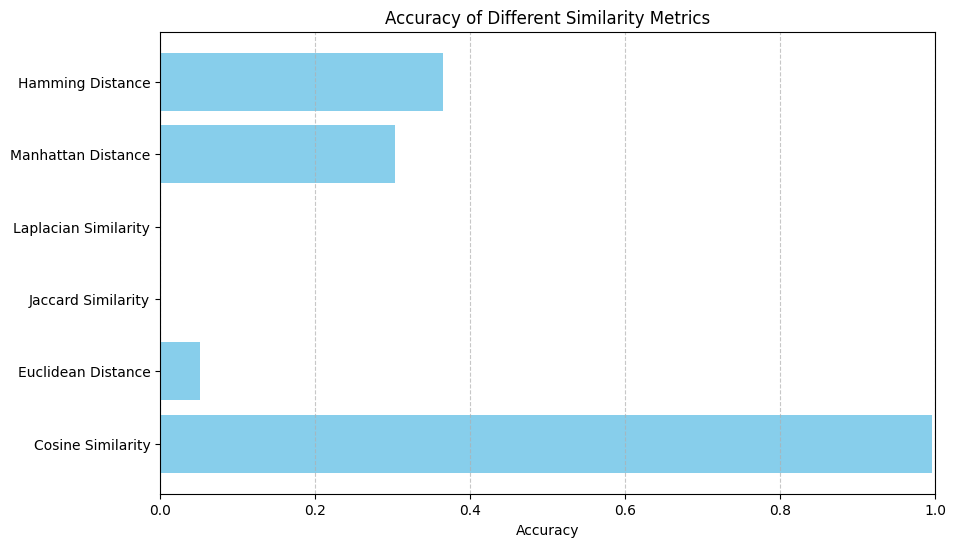

In [31]:
import matplotlib.pyplot as plt
accuracy_values = [
    accuracy_cosine,
    accuracy_euclidean,
    accuracy_jaccard,
    accuracy_laplacian,
    accuracy_manhattan,
    accuracy_hamming
]
metrics = [
    "Cosine Similarity",
    "Euclidean Distance",
    "Jaccard Similarity",
    "Laplacian Similarity",
    "Manhattan Distance",
    "Hamming Distance"
]
plt.figure(figsize=(10, 6))
plt.barh(metrics, accuracy_values, color='skyblue')
plt.xlabel("Accuracy")
plt.title("Accuracy of Different Similarity Metrics")
plt.xlim(0, 1)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()


In [32]:
data.cache()
data.show(10, truncate=False)

+----------------------------------------------------+-----------+--------------+-----------+------------------------------------------+------------------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+------------------+------------------+--------------------+------------------+----------------+------------+----------------------+-------------------+--------------------+----------------------+----------------------+--------------------+
|Text                                                |Sentiment  |User          |Platform   |Hashtags                                  |words                                                       |filtered_words              

In [33]:
data_repartitioned = data.repartition(5, 'User')
data_repartitioned.show(10, truncate=False)

+---------------------------------------------------------+--------------+-----------------+-----------+----------------------------------------------+----------------------------------------------------------+----------------------------------------------------+-----------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+------------------+------------------+--------------------+------------------+----------------+------------+----------------------+-------------------+--------------------+----------------------+----------------------+--------------------+
|Text                                                     |Sentiment     |User             |Platform   |Hashtags                                      |words                                                     |filtered_words                      

In [34]:
import time
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
def measure_execution_time(start_time, end_time):
    return end_time - start_time
start_time = time.time()
data_with_cosine = data.withColumn("cosine_similarity", cosine_udf("raw_features", "tfidf_features"))
end_time = time.time()
cosine_execution_time = measure_execution_time(start_time, end_time)
start_time = time.time()
data_with_jaccard = data.withColumn("jaccard_similarity", jaccard_udf("raw_features", "tfidf_features"))
end_time = time.time()
jaccard_execution_time = measure_execution_time(start_time, end_time)
start_time = time.time()
data_with_euclidean = data.withColumn("euclidean_distance", euclidean_udf("raw_features", "tfidf_features"))
end_time = time.time()
euclidean_execution_time = measure_execution_time(start_time, end_time)
start_time = time.time()
data_with_manhattan = data.withColumn("manhattan_distance", manhattan_udf("raw_features", "tfidf_features"))
end_time = time.time()
manhattan_execution_time = measure_execution_time(start_time, end_time)
start_time = time.time()
data_with_hamming = data.withColumn("hamming_distance", hamming_udf("raw_features", "tfidf_features"))
end_time = time.time()
hamming_execution_time = measure_execution_time(start_time, end_time)

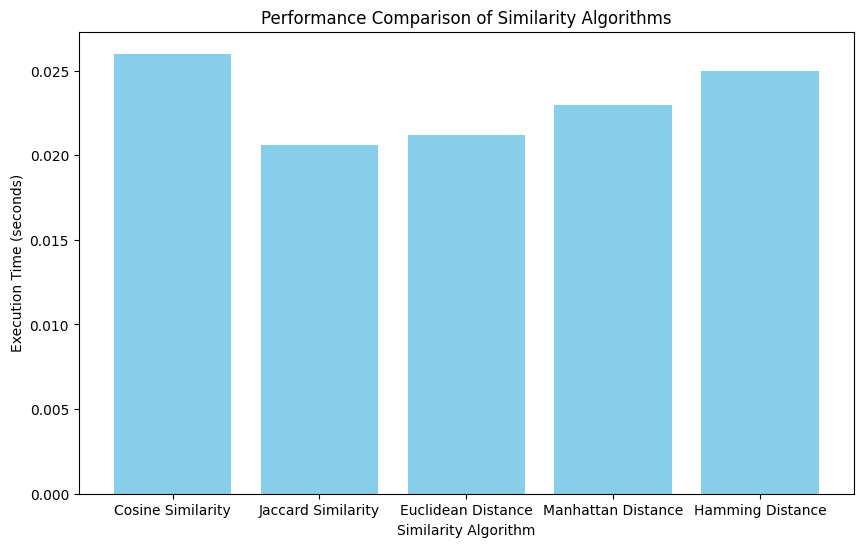

In [35]:
execution_times = {
    'Cosine Similarity': cosine_execution_time,
    'Jaccard Similarity': jaccard_execution_time,
    'Euclidean Distance': euclidean_execution_time,
    'Manhattan Distance': manhattan_execution_time,
    'Hamming Distance': hamming_execution_time
}
plt.figure(figsize=(10, 6))
plt.bar(execution_times.keys(), execution_times.values(), color='skyblue')
plt.xlabel('Similarity Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance Comparison of Similarity Algorithms')
plt.show()